In [5]:
from pathlib import Path
import torchvision.models as models
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import numpy as np
from torch_lr_finder import LRFinder
import os

In [2]:
import pixiedust
import torch
from torch import nn
import pathlib
from torch.utils.data import DataLoader
from torchvision import *

Pixiedust database opened successfully


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
torch.cuda.empty_cache()

In [8]:
transformtrain= transforms.Compose([
    transforms.Resize((124,124)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),              #convert the value to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])         # convert all the value form -1 to 1 for all RGB
])

In [9]:
transformvalid= transforms.Compose([
    transforms.Resize((124,124)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #convert the value to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])         # convert all the value form -1 to 1 for all RGB
])

In [10]:
model =models.resnext50_32x4d(pretrained=True).to(device)

In [11]:
traindata=datasets.ImageFolder('seg_train/seg_train' , transform=transformtrain)

In [12]:
valdata=datasets.ImageFolder('seg_test/seg_test', transform=transformvalid)

In [13]:
trainloader=DataLoader(traindata, batch_size=64, shuffle=True)

In [14]:
 #next(iter(trainloader))

In [15]:
valloader=DataLoader(valdata,batch_size=64,shuffle=True)

In [16]:
len(valloader)

47

In [17]:
classes=['buildings','forest','glacier','mountain','sea','street']

In [18]:
noclass=len(classes)

In [19]:

for param in model.parameters():
    param.requires_grad=False

In [20]:
# for param in model.parameters():
#     print(param)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [22]:
model.fc=nn.Linear(2048,6).to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0000001)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


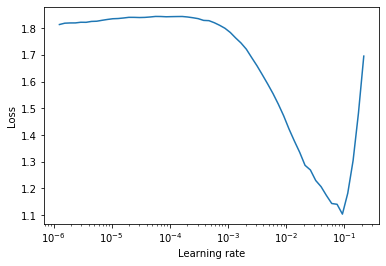

In [23]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=150, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
# optimizer=torch.optim.Adam(model.parameters(),lr=0.00001)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(trainloader, val_loader=valloader, end_lr=100, num_iter=100, step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

In [28]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.0004)

In [29]:
optimizer.zero_grad()

In [30]:
def accuracy(out, yb): 
    return (torch.argmax(out, dim=1)==yb).float().mean()
#%%pixie_debugger

In [31]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    tloss=[]
    vloss=[]
    
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        tot_train=0
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb)
            tot_train+=loss
            loss.backward()
            opt.step()
            opt.zero_grad()
        nt=len(train_dl)
        
        
        
        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        tloss.append(tot_train/nt)
        vloss.append(tot_loss/nv)
        print(epoch,tot_train/nt, tot_loss/nv, tot_acc/nv)
    return tloss, vloss

In [32]:
ltrain,lval = fit(5, model, criterion, optimizer, trainloader, valloader)

0 tensor(0.7167, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4639, device='cuda:0') tensor(0.8573, device='cuda:0')
1 tensor(0.4193, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3902, device='cuda:0') tensor(0.8617, device='cuda:0')
2 tensor(0.3764, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3915, device='cuda:0') tensor(0.8601, device='cuda:0')
3 tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3707, device='cuda:0') tensor(0.8712, device='cuda:0')
4 tensor(0.3385, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3647, device='cuda:0') tensor(0.8692, device='cuda:0')


In [ ]:
plt.plot(ltrain, label='Training loss', color='green')
plt.plot(lval, label='Validation loss', color ='black')
plt.legend(frameon=False)
plt.show()

In [33]:
PATH="C:/Users/Iconsense/Documents/virat/abhi/save1"
torch.save({
            
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            
            
            }, PATH)

In [34]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
# modelB.load_state_dict(checkpoint['modelB_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

# modelA.eval()
# modelB.eval()
# # - or -
model.train()
# modelB.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [37]:
ltrain,lval = fit(5, model, criterion, optimizer, trainloader, valloader)

0 tensor(0.3117, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3379, device='cuda:0') tensor(0.8744, device='cuda:0')
1 tensor(0.3077, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3362, device='cuda:0') tensor(0.8778, device='cuda:0')
2 tensor(0.3043, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3353, device='cuda:0') tensor(0.8800, device='cuda:0')
3 tensor(0.2974, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3501, device='cuda:0') tensor(0.8756, device='cuda:0')
4 tensor(0.2998, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3379, device='cuda:0') tensor(0.8762, device='cuda:0')


In [38]:
PATH="C:/Users/Iconsense/Documents/virat/abhi/save1"
torch.save({
            
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            
            
            }, PATH)

In [39]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
# modelB.load_state_dict(checkpoint['modelB_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

# modelA.eval()
# modelB.eval()
# # - or -
model.train()
# modelB.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

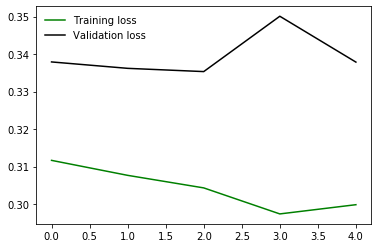

In [40]:
plt.plot(ltrain, label='Training loss', color='green')
plt.plot(lval, label='Validation loss', color ='black')
plt.legend(frameon=False)
plt.show()

In [41]:
from PIL import Image
import numpy as np

In [42]:

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [43]:
img = Image.open('seg_pred/seg_pred/3966.jpg')

In [44]:
nimg = np.array(img)

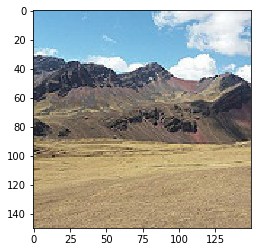

In [45]:
plt.imshow(nimg)


In [46]:
nimg = transformvalid(img).unsqueeze(0).to(device)

In [47]:
nimg.shape

torch.Size([1, 3, 124, 124])

In [48]:
prediction = model(nimg)

In [49]:
_, tpredict = torch.max(prediction.data, 1)

In [50]:
classes[tpredict[0].item()]

'mountain'

In [51]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [52]:
for param in model.parameters():
    param.requires_grad = True

"""optimizer = torch.optim.Adam([{'params': model.layer4.parameters()},
                {'params': model.layer1.parameters(), 'lr': 1e-2},
                {'params': model.layer2.parameters(), 'lr': 1e-4},
            
            ], lr=1e-1)"""

"optimizer = torch.optim.Adam([{'params': model.layer4.parameters()},\n                {'params': model.layer1.parameters(), 'lr': 1e-2},\n                {'params': model.layer2.parameters(), 'lr': 1e-4},\n            \n            ], lr=1e-1)"

In [53]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.00000001)   

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


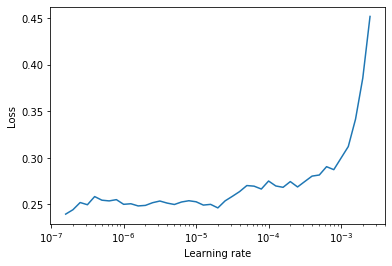

In [54]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [55]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam([{'params': model.layer4.parameters()},
                {'params': model.layer1.parameters(), 'lr': 6e-7},
                 {'params': model.layer2.parameters(), 'lr': 1e-6},
                {'params': model.layer3.parameters(), 'lr': 5e-6}
            ], lr=1e-5)

In [56]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    tloss=[]
    vloss=[]
    
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        tot_train=0
#         print(model.training)
        for xb,yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb)
            tot_train+=loss
            loss.backward()
            opt.step()
            opt.zero_grad()
        nt=len(train_dl)
        
        
        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        tloss.append(tot_train/nt)
        vloss.append(tot_loss/nv)
        print(epoch,tot_train/nt, tot_loss/nv, tot_acc/nv)
    return tloss, vloss

In [57]:
ltrain,lval = fit(6, model, criterion, optimizer, trainloader, valloader)

0 tensor(0.2517, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2651, device='cuda:0') tensor(0.9061, device='cuda:0')
1 tensor(0.1441, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2457, device='cuda:0') tensor(0.9138, device='cuda:0')
2 tensor(0.0983, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2367, device='cuda:0') tensor(0.9216, device='cuda:0')
3 tensor(0.0636, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2522, device='cuda:0') tensor(0.9160, device='cuda:0')
4 tensor(0.0411, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2465, device='cuda:0') tensor(0.9182, device='cuda:0')
5 tensor(0.0291, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2699, device='cuda:0') tensor(0.9164, device='cuda:0')


In [58]:
# criterion = nn.CrossEntropyLoss()
# optimizer=torch.optim.Adam(model.parameters(),lr=0.000001)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(trainloader, val_loader=valloader, end_lr=1, num_iter=100, step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

In [59]:
# for param in model.features.parameters():
#     param.requires_grad = True
    
# optimizer = torch.optim.Adam([{'params': model.classifier.parameters()},
#                 {'params': model.features.parameters(), 'lr': 0.00001}
#             ], lr=0.002)

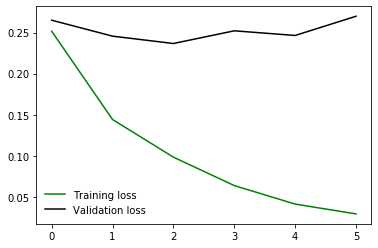

In [60]:

plt.plot(ltrain, label='Training loss', color='green')
plt.plot(lval, label='Validation loss', color ='black')
plt.legend(frameon=False)
plt.show()

In [61]:
PATH="C:/Users/Iconsense/Documents/virat/abhi/save2"
torch.save({
            
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            
            
            }, PATH)

In [62]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
# modelB.load_state_dict(checkpoint['modelB_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

# modelA.eval()
# modelB.eval()
# # - or -
model.train()
# modelB.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1